- 모델
  - 학교급과 학년(초등학교3~6, 중학교 1~3학년, 고등학교 1학년) 를 예측하는 모델

- 학습 목표
  - 한국어 텍스트 데이터 전처리, 특징 추출 (WordCloud)
  - 텍스트 벡터화
  - 하이퍼파라미터 튜닝

- 데이터 출처
  - AI Hub - 수학 교과 문제 풀이과정 데이터
    - https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=71859

- 데이터셋에서 사용할 컬럼
  - school : 학교급 (초등학교, 중학교, 고등학교)
  - grade : 학년 (3~6, 1~3, 1)
  - text_description : 수학 문제의 텍스트 설명

- target(class)
  - 총 8개의 클래스
    - 초등학교 3~6학년, 중학교 1~3학년, 고등학교 1학년

- 목차
  - 라이브러리 설정 및 데이터 불러오기
  - 탐색적 데이터 분석 (EDA)
  - 텍스트 데이터 전처리
  - 특징 추출 및 벡터화
  - 모델 구현 및 학습
  - 모델 성능 평가 및 해석
  - 하이퍼파라미터 튜닝

## 1. 라이브러리 설정 및 데이터 불러오기

In [43]:
# 기본 라이브러리
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams["font.family"] = "Malgun Gothic"

# 파싱 및 텍스트 전처리
import re    # 텍스트 패턴 처리 (정규표현식)
from collections import Counter  # 단어 출현 빈도수 세는 용도
from bs4 import BeautifulSoup   # HTML 태그 등 텍스트 전처리용
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  # 텍스트 벡터화(숫자로 변환)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score  # 데이터 분할, 하이퍼파라미터 최적화, 교차검증
from sklearn.preprocessing import LabelEncoder  # 레이블(문자+숫자) 인코딩

# 머신러닝 라이브러리
from sklearn.linear_model import LogisticRegression  # 로지스틱회귀 분류모델
from sklearn.ensemble import RandomForestClassifier, VotingClassifier  # 랜덤포레스트, 앙상블 모델
from sklearn.svm import SVC  # 서포트벡터 분류모델
from sklearn.naive_bayes import MultinomialNB  # 다항분포 나이브베이즈 모델
from sklearn.metrics import (
    accuracy_score,           # 정확도
    precision_score,          # 정밀도
    recall_score,             # 재현율
    f1_score,                 # F1 스코어
    classification_report,    # 분류 평가 보고서
    confusion_matrix          # 혼동행렬 지표
)

# 경고메시지 숨김용
import warnings
warnings.filterwarnings('ignore')

print('라이브러리 임포트 완료!')

라이브러리 임포트 완료!


In [44]:
# 데이터 불러오기
train_df = pd.read_csv('./data/school_train.csv')
train_df.head()

,school,grade,text_descriptions
0,초등학교,3학년,계산 결과가 3000보다 큰 곱셈식을 모두 선택하세요.\n첫 번째 집: $80 \t...
1,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지 찾아 선택하세요.\n$3\times4$ $30...
2,초등학교,3학년,$\square$ 안의 수가 다른 하나를 찾아 기호를 선택해보세요.\n㉠ $60 \...
3,초등학교,3학년,계산 결과가 큰 것부터 순서대로 나열한 것을 고르세요.\n$4 \times 28$\...
4,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지를 찾아 선택하세요.\n\[ \begin{arr...


In [45]:
test_df = pd.read_csv('./data/school_test.csv')
test_df.head()

,school,grade,text_descriptions
0,초등학교,3학년,가방 $80$개를 $4$개의 상자에 똑같이 나누어 담았습니다. 상자 한 개에 담은 ...
1,초등학교,3학년,학생 $120$명이 체육대회에 참여했습니다. $600$개의 장난감을 학생들에게 똑같...
2,초등학교,3학년,사탕 225개를 15개의 박스에 똑같이 나누어 담았습니다. 박스 한 개에 담은 사탕...
3,초등학교,3학년,도서관에 책 $270$권이 있습니다. 이 책을 $9$개의 책꽂이에 똑같이 나누어 놓...
4,초등학교,3학년,기차 8대에 320명의 승객이 탑승했습니다. 기차 한 대에 탑승한 승객은 몇 명일까요?


In [46]:
print(f"학습 데이터: {train_df.shape[0]}개 데이터, {train_df.shape[1]}개 컬럼")
print(f"테스트 데이터: {test_df.shape[0]}개 데이터, {test_df.shape[1]}개 컬럼")

train_df.columns.tolist()  # 컬럼명 리스트 출력

학습 데이터: 16248개 데이터, 3개 컬럼
테스트 데이터: 2032개 데이터, 3개 컬럼


['school', 'grade', 'text_descriptions']

In [47]:
train_df.head()

,school,grade,text_descriptions
0,초등학교,3학년,계산 결과가 3000보다 큰 곱셈식을 모두 선택하세요.\n첫 번째 집: $80 \t...
1,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지 찾아 선택하세요.\n$3\times4$ $30...
2,초등학교,3학년,$\square$ 안의 수가 다른 하나를 찾아 기호를 선택해보세요.\n㉠ $60 \...
3,초등학교,3학년,계산 결과가 큰 것부터 순서대로 나열한 것을 고르세요.\n$4 \times 28$\...
4,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지를 찾아 선택하세요.\n\[ \begin{arr...


학교급, 학년, 문제 3가지 컬럼이 있고, 문제에는 수식이 포함되어있다.

## 탐색적 데이터 분석 (EDA)

In [48]:
train_df.info()  # 데이터 기본정보 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16248 entries, 0 to 16247
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   school             16248 non-null  object
 1   grade              16248 non-null  object
 2   text_descriptions  16248 non-null  object
dtypes: object(3)
memory usage: 380.9+ KB


In [49]:
train_df.isnull().sum()  # 학습데이터 결측치 수 확인

school               0
grade                0
text_descriptions    0
dtype: int64

In [50]:
test_df.isnull().sum()  # 테스트데이터 결측치 수 확인

school               0
grade                0
text_descriptions    0
dtype: int64

In [51]:
# 만약 결측치가 존재한다면
# train_df.dropna(inplace=True)

# 만약 결측치가 text_descriptions 컬럼의 결측치 행을 제거하고싶다면
# train_df.dropna(subset=['text_descriptions'], inplace=True)

# 다시 한번 확인
train_df.isnull().sum()

school               0
grade                0
text_descriptions    0
dtype: int64

In [52]:
# 타겟 변수 생성 (학교급 + 학년)
train_df["school_grade"] = train_df["school"] + " " + train_df["grade"]
train_df

,school,grade,text_descriptions,school_grade
0,초등학교,3학년,계산 결과가 3000보다 큰 곱셈식을 모두 선택하세요.\n첫 번째 집: $80 \t...,초등학교 3학년
1,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지 찾아 선택하세요.\n$3\times4$ $30...,초등학교 3학년
2,초등학교,3학년,$\square$ 안의 수가 다른 하나를 찾아 기호를 선택해보세요.\n㉠ $60 \...,초등학교 3학년
3,초등학교,3학년,계산 결과가 큰 것부터 순서대로 나열한 것을 고르세요.\n$4 \times 28$\...,초등학교 3학년
4,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지를 찾아 선택하세요.\n\[ \begin{arr...,초등학교 3학년
...,...,...,...,...
16243,고등학교,1학년,유리함수 $y=\frac{x+a}{b x+c}$의 그래프가 오른쪽 그림과 같고이 그...,고등학교 1학년
16244,고등학교,1학년,유리함수 $y=\frac{k x}{x+3}$의 그래프가 직선 $y=x$에 대하여 대...,고등학교 1학년
16245,고등학교,1학년,분모를 0으로 하지 않는 모든 실수 $x$에 대하여 등식 \[ \begin{arra...,고등학교 1학년
16246,고등학교,1학년,오른쪽 그림과 같이 유리 함수 $y=\frac{9}{x}+2(x>0)$의 그래프 위...,고등학교 1학년


타겟 변수 분포 확인

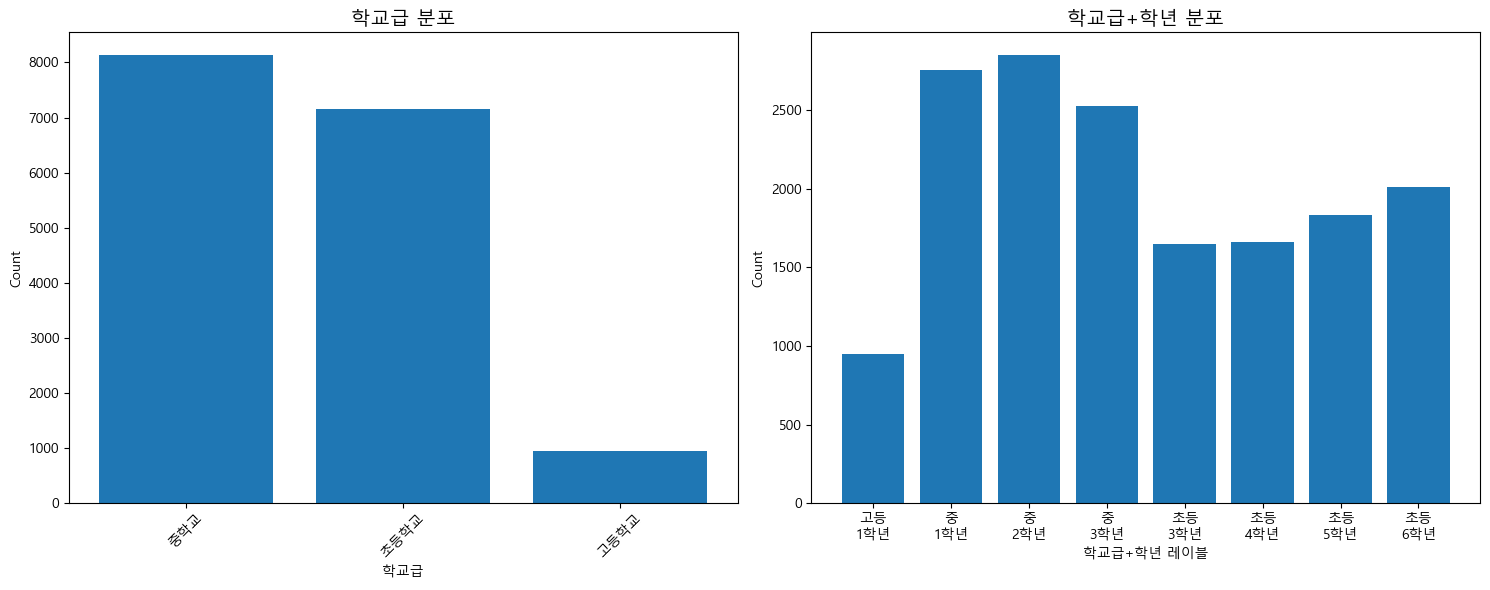

In [53]:
# 타겟 변수 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1행 2열

# 학교급 분포 (예: 초등/중등/고등)
school_counts = train_df['school'].value_counts()
# school_counts
axes[0].bar(school_counts.index, school_counts.values)  # 막대그래프
axes[0].set_title("학교급 분포", fontsize=14)
axes[0].set_xlabel("학교급")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)  # X축 라벨 설정

# 학교급-학년 조합 분포 (예: 초등 3, 중등 1, ...)
school_grade_counts = train_df['school_grade'].value_counts().sort_index()
axes[1].bar(range(len(school_grade_counts)), school_grade_counts.values)  # 막대그래프
axes[1].set_title("학교급+학년 분포", fontsize=14)
axes[1].set_xlabel("학교급+학년 레이블")
axes[1].set_ylabel("Count")
axes[1].set_xticks(range(len(school_grade_counts)))  # x축 눈금 설정
axes[1].set_xticklabels([sg.replace('학교', '').replace(' ', '\n') for sg in school_grade_counts.index], rotation=0)

plt.tight_layout()
plt.show()

고등학교 문제를 잘 못맞출 가능성이 있고, 그 밖에는 초등학교 3, 4학년 정도가 데이터가 적다.

In [54]:
# 클래스 불균형 분석

class_ratio = school_grade_counts / school_grade_counts.sum() * 100  # 각 클래스가 전체에서 차지하는 비율 계산
for class_name, ratio in class_ratio.items():
    print(f"{class_name}: {ratio:.2f}%")

imbalance_ratio = school_grade_counts.max() / school_grade_counts.min()
print(f"\n최대/최소 클래스 비율: {imbalance_ratio:.2f}")

고등학교 1학년: 5.86%
중학교 1학년: 16.95%
중학교 2학년: 17.57%
중학교 3학년: 15.58%
초등학교 3학년: 10.14%
초등학교 4학년: 10.25%
초등학교 5학년: 11.27%
초등학교 6학년: 12.40%

최대/최소 클래스 비율: 3.00


고등학교 문제가 적다!

텍스트 데이터 분석

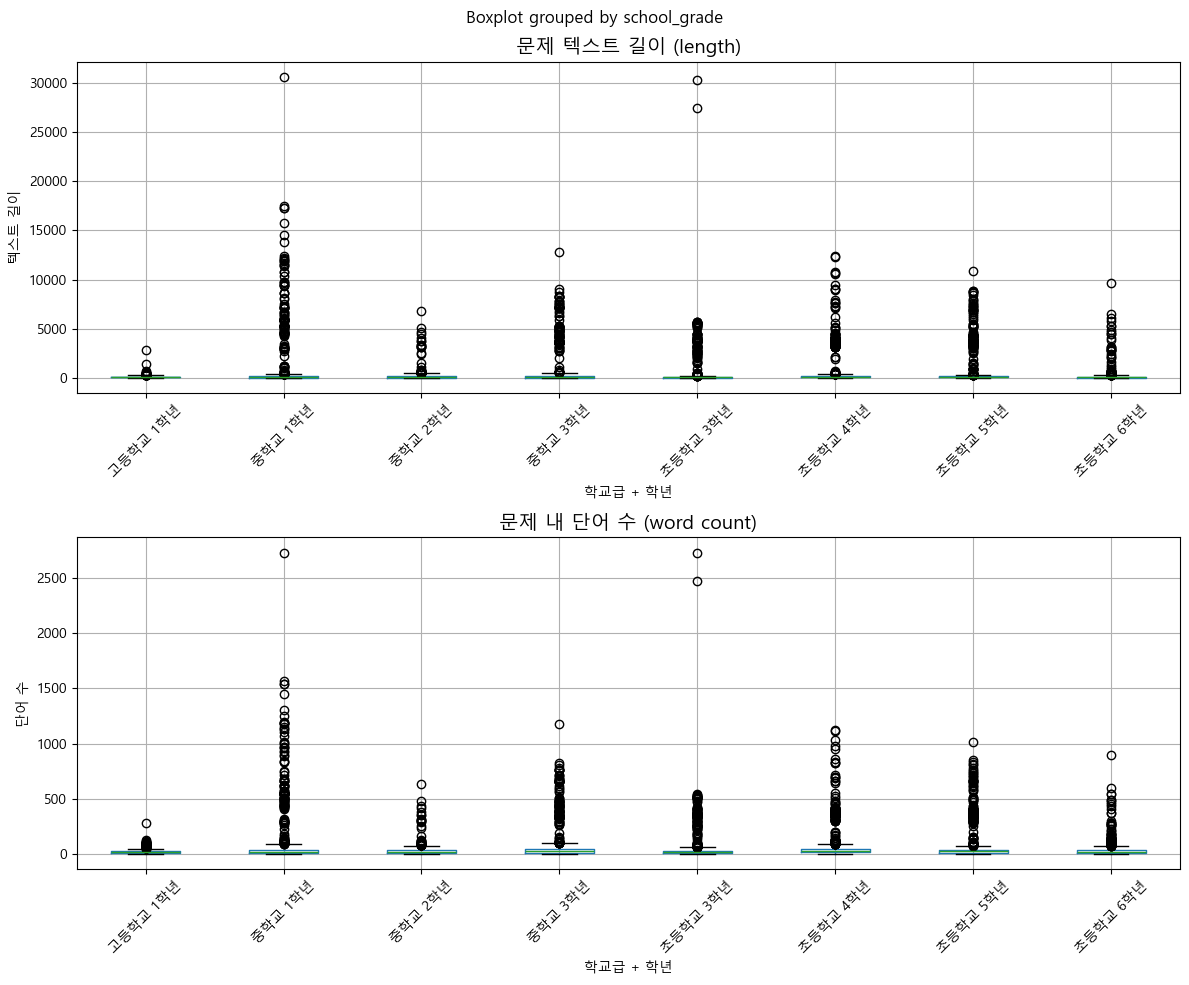

In [55]:
# 텍스트 길이 및 단어 수 분석
train_df['text_length'] = train_df['text_descriptions'].str.len()   # 텍스트(문제) 글자 수
train_df['word_count'] = train_df['text_descriptions'].str.split().str.len()  # 텍스트 내 단어 수

# print(train_df['text_length'].shape[0])
# print(train_df['word_count'].shape[0])

# 학교급별 텍스트 길이 분포 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 텍스트 길이(글자 수) 박스플롯
train_df.boxplot(column='text_length', by='school_grade', ax=axes[0])
axes[0].set_title("문제 텍스트 길이 (length)", fontsize=14)
axes[0].set_xlabel('학교급 + 학년')
axes[0].set_ylabel('텍스트 길이')
axes[0].tick_params(axis='x', rotation=45)

# 단어 수 박스플롯
train_df.boxplot(column='word_count', by='school_grade', ax=axes[1])
axes[1].set_title("문제 내 단어 수 (word count)", fontsize=14)
axes[1].set_xlabel('학교급 + 학년')
axes[1].set_ylabel('단어 수')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

텍스트 기준 1000자, 단어수 200개 글자 정도안에 들어와야 정상일 것으로 보인다.
이상치 처리가 필요하다.

In [56]:
train_df[train_df['text_length'] > 1000]

,school,grade,text_descriptions,school_grade,text_length,word_count
97,초등학교,3학년,"지름을 나타내는 선분을 찾아 길이를 잰 값을 보고, 맞는 말을 선택해 보 세요.\n...",초등학교 3학년,2456,251
154,초등학교,3학년,"지름을 나타내는 선분을 찾아 길이를 재어 보고, 알 수 있는 점을 쓰려고 합니다. ...",초등학교 3학년,2295,242
181,초등학교,3학년,블루베리 주스 2 잔을 만드는 데 필요한 재료입니다. 필요한 양이 가분수 인 재료를...,초등학교 3학년,4168,382
193,초등학교,3학년,블루베리 주스 $2$잔을 만드는 데 필요한 재료입니다. 필요한 양이 진분수인 재료를...,초등학교 3학년,3090,287
194,초등학교,3학년,블루베리 주스 2 잔을 만드는 데 필요한 재료입니다. 필요한 양이 진분수\n인 재료...,초등학교 3학년,3627,339
...,...,...,...,...,...,...
15251,중학교,3학년,오른쪽 삼각비의 표를 보고 $\tan 22^{\circ}+\sin 23^{\circ...,중학교 3학년,4919,448
15261,중학교,3학년,"$\sin x=0. 2419, \cos y=0. 9744$ 일 때, 다음 삼각비의 ...",중학교 3학년,6273,574
15267,중학교,3학년,강한 태풍에 의하여 전신주가 오른쪽 그림과 같이 부러졌 다. 이 전신주가 부러지기 ...,중학교 3학년,3789,380
16017,고등학교,1학년,"A, B 두 종류의 아이스크림을 각각 한 통씩 만드는데 필요한 우유와 설탕의 양은 ...",고등학교 1학년,2827,279


In [57]:
# 텍스트 길이가 1000자 초과인 샘플 중 첫 번째 문제 풀이 과정 출력
print(train_df[train_df['text_length'] > 1000]['text_descriptions'].iloc[0])

지름을 나타내는 선분을 찾아 길이를 잰 값을 보고, 맞는 말을 선택해 보 세요.
한 원에서 원의 지름은 모두 (같습니다, 다릅니다).
정원형이 있고 중심에는 ㅇ 가 있습니다. 점 ㅇ와 연결된 꼭짓점 (ㄷ, ㅅ, ㄴ, ㄷ, ㄹ, ㅁ, ㅂ)가 있습니다.
<div class="table_tabular " style="text-align: center"> <div class="inline-tabular"><table id="tabular"> <tbody> <tr style="border-top: none !important; border-bottom: none !important;"> <td style="text-align: center; border-left: none !important; border-right-style: solid !important; border-right-width: 1px !important; border-bottom-style: solid !important; border-bottom-width: 1px !important; border-top-style: solid !important; border-top-width: 1px !important; width: auto; vertical-align: middle; ">지름</td> <td style="text-align: center; border-right-style: solid !important; border-right-width: 1px !important; border-bottom-style: solid !important; border-bottom-width: 1px !important; border-top-style: solid !important; border-top-width: 1px !important; width: auto; vertical-align: middle; ">선분 ㄱㅁ</td> <td style="text-align: center; border-right-

HTML 태그가 들어있다. 이거는 삭제가 필요한 부분이라고 판단된다.

In [58]:
# HTML 태그 제거 함수 (BeautifulSoup 사용)
def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

# 'text_descriptions' 컬럼에 함수 적용. HTML 태그가 없는 새로운 컬럼 생성
train_df["text_descriptions_clean"] = train_df["text_descriptions"].apply(remove_html_tags)

In [59]:
train_df[train_df["text_length"] > 1000]

,school,grade,text_descriptions,school_grade,text_length,word_count,text_descriptions_clean
97,초등학교,3학년,"지름을 나타내는 선분을 찾아 길이를 잰 값을 보고, 맞는 말을 선택해 보 세요.\n...",초등학교 3학년,2456,251,"지름을 나타내는 선분을 찾아 길이를 잰 값을 보고, 맞는 말을 선택해 보 세요.\n..."
154,초등학교,3학년,"지름을 나타내는 선분을 찾아 길이를 재어 보고, 알 수 있는 점을 쓰려고 합니다. ...",초등학교 3학년,2295,242,"지름을 나타내는 선분을 찾아 길이를 재어 보고, 알 수 있는 점을 쓰려고 합니다. ..."
181,초등학교,3학년,블루베리 주스 2 잔을 만드는 데 필요한 재료입니다. 필요한 양이 가분수 인 재료를...,초등학교 3학년,4168,382,블루베리 주스 2 잔을 만드는 데 필요한 재료입니다. 필요한 양이 가분수 인 재료를...
193,초등학교,3학년,블루베리 주스 $2$잔을 만드는 데 필요한 재료입니다. 필요한 양이 진분수인 재료를...,초등학교 3학년,3090,287,블루베리 주스 $2$잔을 만드는 데 필요한 재료입니다. 필요한 양이 진분수인 재료를...
194,초등학교,3학년,블루베리 주스 2 잔을 만드는 데 필요한 재료입니다. 필요한 양이 진분수\n인 재료...,초등학교 3학년,3627,339,블루베리 주스 2 잔을 만드는 데 필요한 재료입니다. 필요한 양이 진분수\n인 재료...
...,...,...,...,...,...,...,...
15251,중학교,3학년,오른쪽 삼각비의 표를 보고 $\tan 22^{\circ}+\sin 23^{\circ...,중학교 3학년,4919,448,오른쪽 삼각비의 표를 보고 $\tan 22^{\circ}+\sin 23^{\circ...
15261,중학교,3학년,"$\sin x=0. 2419, \cos y=0. 9744$ 일 때, 다음 삼각비의 ...",중학교 3학년,6273,574,"$\sin x=0. 2419, \cos y=0. 9744$ 일 때, 다음 삼각비의 ..."
15267,중학교,3학년,강한 태풍에 의하여 전신주가 오른쪽 그림과 같이 부러졌 다. 이 전신주가 부러지기 ...,중학교 3학년,3789,380,강한 태풍에 의하여 전신주가 오른쪽 그림과 같이 부러졌 다. 이 전신주가 부러지기 ...
16017,고등학교,1학년,"A, B 두 종류의 아이스크림을 각각 한 통씩 만드는데 필요한 우유와 설탕의 양은 ...",고등학교 1학년,2827,279,"A, B 두 종류의 아이스크림을 각각 한 통씩 만드는데 필요한 우유와 설탕의 양은 ..."


In [60]:
# 글자수가 1000개 이상인 데이터 중 "text_descriptions_clean" 컬럼 맨 위에꺼 하나만 출력
print(train_df[train_df["text_length"] > 1000]["text_descriptions_clean"].iloc[0])

지름을 나타내는 선분을 찾아 길이를 잰 값을 보고, 맞는 말을 선택해 보 세요.
한 원에서 원의 지름은 모두 (같습니다, 다릅니다).
정원형이 있고 중심에는 ㅇ 가 있습니다. 점 ㅇ와 연결된 꼭짓점 (ㄷ, ㅅ, ㄴ, ㄷ, ㄹ, ㅁ, ㅂ)가 있습니다.
    지름 선분 ㄱㅁ 선분 ㄴㅂ 선분 ㄹㅅ   길이  $(\mathrm{cm})$ 3 3 3    


현재 상태 : text_descriptions_clean 컬럼 값에는 html 태그 삭제 완료

In [61]:
# text_descriptions_clean 내용을 text_descriptions 에 덮어씌우고, text_descriptions_clean 컬럼은 삭제한다.
train_df['text_descriptions'] = train_df['text_descriptions_clean']
train_df.drop(columns=['text_descriptions_clean'], inplace=True)

In [62]:
train_df

,school,grade,text_descriptions,school_grade,text_length,word_count
0,초등학교,3학년,계산 결과가 3000보다 큰 곱셈식을 모두 선택하세요.\n첫 번째 집: $80 \t...,초등학교 3학년,122,31
1,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지 찾아 선택하세요.\n$3\times4$ $30...,초등학교 3학년,101,21
2,초등학교,3학년,$\square$ 안의 수가 다른 하나를 찾아 기호를 선택해보세요.\n㉠ $60 \...,초등학교 3학년,130,26
3,초등학교,3학년,계산 결과가 큰 것부터 순서대로 나열한 것을 고르세요.\n$4 \times 28$\...,초등학교 3학년,72,17
4,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지를 찾아 선택하세요.\n\[ \begin{arr...,초등학교 3학년,248,50
...,...,...,...,...,...,...
16243,고등학교,1학년,유리함수 $y=\frac{x+a}{b x+c}$의 그래프가 오른쪽 그림과 같고이 그...,고등학교 1학년,272,56
16244,고등학교,1학년,유리함수 $y=\frac{k x}{x+3}$의 그래프가 직선 $y=x$에 대하여 대...,고등학교 1학년,68,13
16245,고등학교,1학년,분모를 0으로 하지 않는 모든 실수 $x$에 대하여 등식 \[ \begin{arra...,고등학교 1학년,210,28
16246,고등학교,1학년,오른쪽 그림과 같이 유리 함수 $y=\frac{9}{x}+2(x>0)$의 그래프 위...,고등학교 1학년,271,38


In [63]:
# test_df 에도 동일한 로직을 적용해 전처리한다.
test_df["text_descriptions_clean"] = test_df["text_descriptions"].apply(remove_html_tags)

test_df['text_descriptions'] = test_df['text_descriptions_clean']
test_df.drop(columns=['text_descriptions_clean'], inplace=True)
test_df

,school,grade,text_descriptions
0,초등학교,3학년,가방 $80$개를 $4$개의 상자에 똑같이 나누어 담았습니다. 상자 한 개에 담은 ...
1,초등학교,3학년,학생 $120$명이 체육대회에 참여했습니다. $600$개의 장난감을 학생들에게 똑같...
2,초등학교,3학년,사탕 225개를 15개의 박스에 똑같이 나누어 담았습니다. 박스 한 개에 담은 사탕...
3,초등학교,3학년,도서관에 책 $270$권이 있습니다. 이 책을 $9$개의 책꽂이에 똑같이 나누어 놓...
4,초등학교,3학년,기차 8대에 320명의 승객이 탑승했습니다. 기차 한 대에 탑승한 승객은 몇 명일까요?
...,...,...,...
2027,고등학교,1학년,6명의 학생을 다음과 같이 3개의 조로 나누는 모든 방법의 수를 구하시오.\n① 1...
2028,고등학교,1학년,"A, B, C, A의 네 지점이 오른쪽 그림과 같이 서로 여러 개의 길로 연결되어 ..."
2029,고등학교,1학년,"오른쪽 그림과 같이 평행한 두 직선 $l$, $m$ 위에 점이 각각 $3$개, $4..."
2030,고등학교,1학년,"오른쪽 그림과 같이 삼각형 위에 서로 다른 9개의 점 $\mathrm{A}_{1},..."


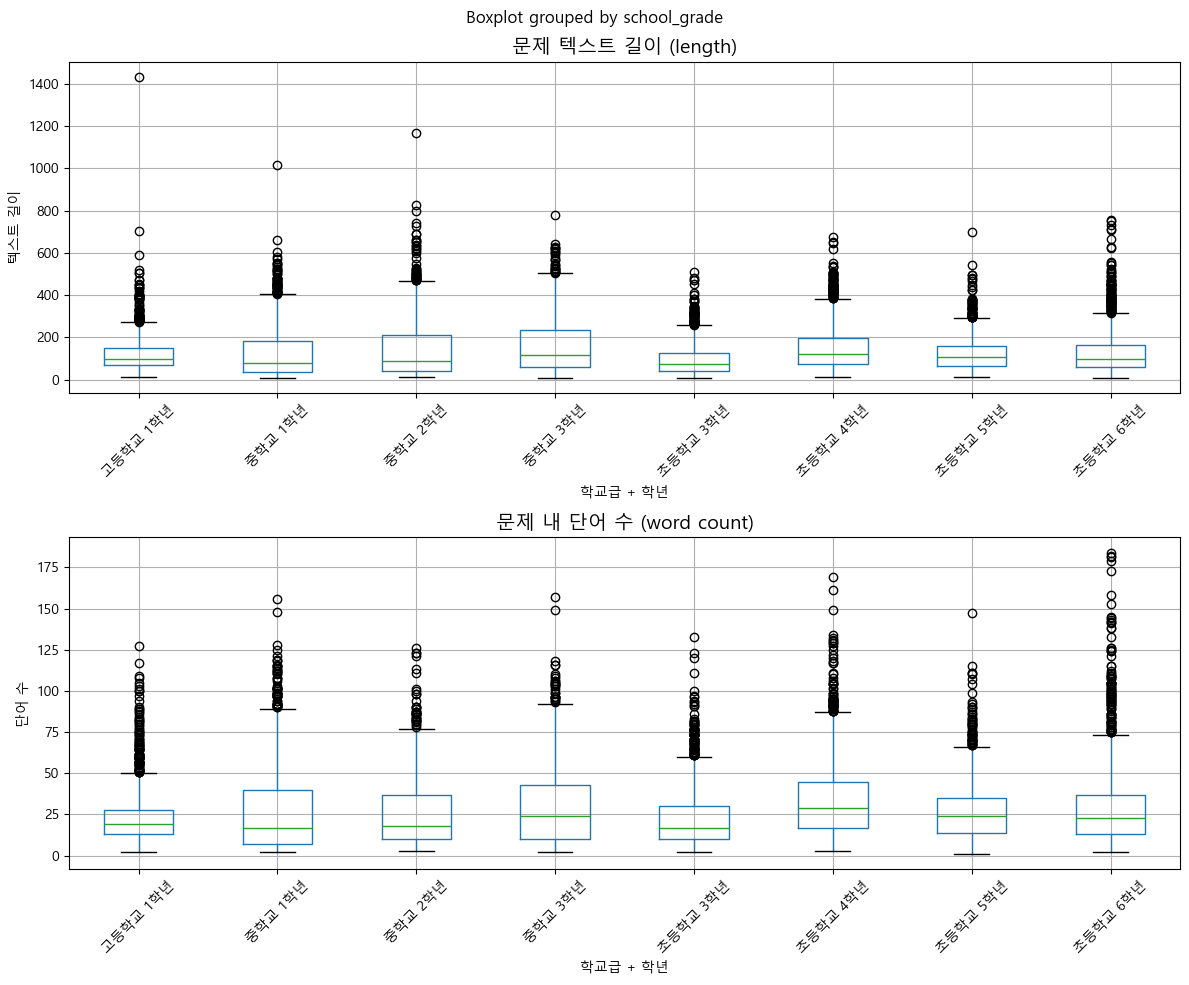

In [64]:
# 텍스트 길이 및 단어 수 분석
train_df['text_length'] = train_df['text_descriptions'].str.len()   # 텍스트(문제) 글자 수
train_df['word_count'] = train_df['text_descriptions'].str.split().str.len()  # 텍스트 내 단어 수

# 학교급별 텍스트 길이 분포 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 텍스트 길이(글자 수) 박스플롯
train_df.boxplot(column='text_length', by='school_grade', ax=axes[0])
axes[0].set_title("문제 텍스트 길이 (length)", fontsize=14)
axes[0].set_xlabel('학교급 + 학년')
axes[0].set_ylabel('텍스트 길이')
axes[0].tick_params(axis='x', rotation=45)

# 단어 수 박스플롯
train_df.boxplot(column='word_count', by='school_grade', ax=axes[1])
axes[1].set_title("문제 내 단어 수 (word count)", fontsize=14)
axes[1].set_xlabel('학교급 + 학년')
axes[1].set_ylabel('단어 수')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

학년이 올라갈수록 길이가 길어진다. 하지만 고등학교는 표본수가 적어서인지 구별하기가 애매할 수 있겠다.

In [65]:
# 학년별 텍스트 길이 및 단어 수의 평균, 표준편차 집계
text_stats = train_df.groupby('school_grade')[["text_length", "word_count"]].agg(["mean", "std"])
print(text_stats.round(2))

             text_length         word_count       
                    mean     std       mean    std
school_grade                                      
고등학교 1학년          126.61   97.75      24.32  19.22
중학교 1학년           122.35  109.35      26.00  23.96
중학교 2학년           140.89  124.45      24.80  18.71
중학교 3학년           155.97  121.82      28.47  21.59
초등학교 3학년           95.26   74.83      22.63  18.22
초등학교 4학년          150.23  104.93      34.43  23.83
초등학교 5학년          121.03   76.15      27.02  17.54
초등학교 6학년          125.24   96.21      29.02  23.82


학교급과 학년별로는 글자수나 문장수로 판단이 될만한 요소는 있지만, 고등학교가 애매하다.
그래서 특징으로 자주 나오는 단어등을 같이 추가를 해줘야 정확한 결과를 얻을 수 있을 것으로 판단이 된다.

In [66]:
# 학년별 특징적인 단어 추출 (상위 10개)

for grade in train_df['school_grade'].unique():  # train_df['school_grade'].unique() : array(['초등학교 3학년', '초등학교 4학년', '초등학교 5학년', '초등학교 6학년', '중학교 1학년', '중학교 2학년', '중학교 3학년', '고등학교 1학년'], dtype=object)
    # 학년별 하나의 문자열로 text_descriptions를 묶어준다.
    grade_texts = " ".join(train_df[train_df["school_grade"] == grade]["text_descriptions"].tolist())

    # 한글 단어만 추출 (정규표현식 사용)
    words = re.findall(r"[가-힣]+", grade_texts)
    word_counts = Counter(words)

    # 조사 삭제 (예) 에, 의, 를, ...)
    stopwords = ["의", "를", "을", "과", "에", "는", "이", "가", "하고", "에서", "으로", "로", "와"]
    for sw in stopwords:
        word_counts.pop(sw, None)
    
    print(grade)
    for word, count in word_counts.most_common(10):  # 상위 10개 단어
        print(f"{word}: {count}회")

초등학교 3학년
있습니다: 461회
선택하세요: 453회
모두: 311회
수: 299회
있다: 298회
두: 291회
것을: 271회
큰: 269회
몇: 245회
가장: 238회
초등학교 4학년
있습니다: 882회
선택하세요: 754회
있다: 473회
것을: 461회
수: 450회
두: 397회
나타낸: 397회
있는: 340회
알맞은: 328회
찾아: 315회
초등학교 5학년
보세요: 961회
있다: 542회
것을: 482회
찾아: 443회
선택하세요: 400회
수: 394회
선택해: 359회
있습니다: 348회
모두: 328회
두: 324회
초등학교 6학년
보세요: 1207회
있습니다: 771회
개: 629회
있다: 499회
선택해: 496회
본: 445회
모양을: 430회
개의: 415회
찾아: 405회
인: 385회
중학교 1학년
다음: 1139회
오른쪽: 908회
때: 851회
구하시오: 643회
있다: 626회
있습니다: 597회
두: 590회
점: 553회
중: 513회
계산하시오: 484회
중학교 2학년
때: 1422회
다음: 1237회
점: 1065회
오른쪽: 970회
구하시오: 883회
일: 866회
삼각형: 667회
길이는: 652회
있습니다: 651회
그림과: 604회
중학교 3학년
점: 1346회
때: 1168회
오른쪽: 1099회
있습니다: 1076회
다음: 836회
일: 785회
원: 736회
길이는: 692회
각: 632회
있다: 568회
고등학교 1학년
때: 530회
구하시오: 477회
두: 325회
대하여: 306회
값을: 300회
점: 293회
다음: 244회
일: 199회
실수: 148회
집합: 140회


In [67]:
test_df['school_grade'] = test_df['school'] + " " + test_df['grade']
test_df

,school,grade,text_descriptions,school_grade
0,초등학교,3학년,가방 $80$개를 $4$개의 상자에 똑같이 나누어 담았습니다. 상자 한 개에 담은 ...,초등학교 3학년
1,초등학교,3학년,학생 $120$명이 체육대회에 참여했습니다. $600$개의 장난감을 학생들에게 똑같...,초등학교 3학년
2,초등학교,3학년,사탕 225개를 15개의 박스에 똑같이 나누어 담았습니다. 박스 한 개에 담은 사탕...,초등학교 3학년
3,초등학교,3학년,도서관에 책 $270$권이 있습니다. 이 책을 $9$개의 책꽂이에 똑같이 나누어 놓...,초등학교 3학년
4,초등학교,3학년,기차 8대에 320명의 승객이 탑승했습니다. 기차 한 대에 탑승한 승객은 몇 명일까요?,초등학교 3학년
...,...,...,...,...
2027,고등학교,1학년,6명의 학생을 다음과 같이 3개의 조로 나누는 모든 방법의 수를 구하시오.\n① 1...,고등학교 1학년
2028,고등학교,1학년,"A, B, C, A의 네 지점이 오른쪽 그림과 같이 서로 여러 개의 길로 연결되어 ...",고등학교 1학년
2029,고등학교,1학년,"오른쪽 그림과 같이 평행한 두 직선 $l$, $m$ 위에 점이 각각 $3$개, $4...",고등학교 1학년
2030,고등학교,1학년,"오른쪽 그림과 같이 삼각형 위에 서로 다른 9개의 점 $\mathrm{A}_{1},...",고등학교 1학년


In [68]:
target_classes = sorted(train_df['school_grade'].unique())  # 타겟 클래스 목록(오름차순 정렬)
for i, tc in enumerate(target_classes):
    print(f"{i}: {tc}")  # 클래스 번호와 클래스명 출력

0: 고등학교 1학년
1: 중학교 1학년
2: 중학교 2학년
3: 중학교 3학년
4: 초등학교 3학년
5: 초등학교 4학년
6: 초등학교 5학년
7: 초등학교 6학년


- 레이블 인코딩
  - 문자형 범주형 변수를 숫자로 변환

In [69]:
# school_grade를 숫자형 타겟으로 변환
label_encoder = LabelEncoder()
train_df['target'] = label_encoder.fit_transform(train_df['school_grade'])  # 학습 데이터 인코딩
test_df['target'] = label_encoder.transform(test_df['school_grade'])        # 테스트 데이터 인코딩

train_df

,school,grade,text_descriptions,school_grade,text_length,word_count,target
0,초등학교,3학년,계산 결과가 3000보다 큰 곱셈식을 모두 선택하세요.\n첫 번째 집: $80 \t...,초등학교 3학년,122,31,4
1,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지 찾아 선택하세요.\n$3\times4$ $30...,초등학교 3학년,101,21,4
2,초등학교,3학년,$\square$ 안의 수가 다른 하나를 찾아 기호를 선택해보세요.\n㉠ $60 \...,초등학교 3학년,130,26,4
3,초등학교,3학년,계산 결과가 큰 것부터 순서대로 나열한 것을 고르세요.\n$4 \times 28$\...,초등학교 3학년,72,17,4
4,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지를 찾아 선택하세요.\n\[ \begin{arr...,초등학교 3학년,248,50,4
...,...,...,...,...,...,...,...
16243,고등학교,1학년,유리함수 $y=\frac{x+a}{b x+c}$의 그래프가 오른쪽 그림과 같고이 그...,고등학교 1학년,272,56,0
16244,고등학교,1학년,유리함수 $y=\frac{k x}{x+3}$의 그래프가 직선 $y=x$에 대하여 대...,고등학교 1학년,68,13,0
16245,고등학교,1학년,분모를 0으로 하지 않는 모든 실수 $x$에 대하여 등식 \[ \begin{arra...,고등학교 1학년,210,28,0
16246,고등학교,1학년,오른쪽 그림과 같이 유리 함수 $y=\frac{9}{x}+2(x>0)$의 그래프 위...,고등학교 1학년,271,38,0


### 4. 특징 추출 및 벡터화
- TF-ITF : 얼마나 자주 단어가 나오느냐(TF), 단어가 전체 문서 중 몇개 문서에 등장하는가(IDF)
  - 하나의 문서에서 단어의 중요도를 빈도수(TF - Term Frequency)로 표현한다. - 전체 문서에서의 희귀도(IDF - Inverse Document Frequency) 를 결합해서 측정하는 방식

In [70]:
tfidf_vectorizer = TfidfVectorizer(
    max_features = 1000,     # 최대 feature 수 : 추출할 최대 단어 수
    min_df = 2,              # 최소 문서 빈도 : 최소 2개 문서에는 등장해야 feature로 사용
    max_df = 0.8,            # 최대 문서 빈도 : 전체 문서 중 80% 이하에서 등장하는 단어만 사용
    ngram_range = (1, 3),    # 1~3단어 조합까지 벡터화 (unigram, bigram, trigram)
    sublinear_tf = True,     # tf 값에 log 적용: 빈도수에 log 스케일 적용
    use_idf = True           # IDF 사용
)

# 학습 데이터로 벡터라이저 학습 및 변환 (문자->벡터)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['text_descriptions'])
# 테스트 데이터로 벡터라이저 학습데이터와 동일한 기준으로 변환 (문자->벡터)
X_test_tfidf = tfidf_vectorizer.transform(test_df['text_descriptions'])

print(f"Train : {X_train_tfidf.shape}")
print(f"Test : {X_test_tfidf.shape}")

Train : (16248, 1000)
Test : (2032, 1000)


- CounterVectorizer
  - 텍스트 데이터를 숫자 벡터로 변환할때 가장 기본적인 방식.
  - 각 문서에 어떤 단어가 몇번 등장했는지 세어주는 도구

In [71]:
# CountVectorizer 객체 생성(파라미터는 TF-IDF와 동일, 단어 빈도수 벡터화)
count_vectorizer = CountVectorizer(
    max_features= 1000,
    min_df = 2,
    max_df = 0.8,
    ngram_range = (1, 3)
)

X_train_count = count_vectorizer.fit_transform(train_df['text_descriptions'])
X_test_count = count_vectorizer.transform(test_df['text_descriptions'])

print(f"Train : {X_train_count.shape}")
print(f"Test : {X_test_count.shape}")

Train : (16248, 1000)
Test : (2032, 1000)


- 추가 특징 생성
  - 텍스트 길이
  - 수학 기호, 숫자 관련 특징
  - 특정 키워드 포함 여부
  - 문장 복잡도
  - 괄호 사용

In [72]:
features = train_df['text_length'] = train_df['text_descriptions'].str.len()
features

0        122
1        101
2        130
3         72
4        248
        ... 
16243    272
16244     68
16245    210
16246    271
16247    102
Name: text_descriptions, Length: 16248, dtype: int64

In [73]:
features = train_df['text_descriptions'].str.split().str.len()   # 단어 수
features

0        31
1        21
2        26
3        17
4        50
         ..
16243    56
16244    13
16245    28
16246    38
16247    16
Name: text_descriptions, Length: 16248, dtype: int64

- 정규표현식
  - r (raw string): 문자 그대로
  - \ : 약속된 패턴 사용
  
  - d 만 사용 하는경우 : 문자
  - \d : 숫자 1개
  - \d+ : 숫자 여러개 (2자리이상)
  - \w : 문자+숫자+_
  - \s : 공백
  - \D : 숫자가 아닌 것
  - \\. : .

In [74]:
# 추가 특징 생성 함수
def extract_additional_features(df):

    features = pd.DataFrame()

    # 텍스트 길이, 단어 수, 평균 단어 길이
    features['text_length'] = df['text_descriptions'].str.len()   # 전체 글자 수
    features['word_count'] = df['text_descriptions'].str.split().str.len()   # 단어 수
    features['avg_word_length'] = features['text_length'] / (features['word_count'] + 1)  # 평균 단어 길이 (분모에 0이 들어오는 경우 오류 방지)

    # 수학 기호, 숫자 관련 특징 패턴 추출
    features['num_count'] = df['text_descriptions'].str.count(r'\d+')   # 숫자 등장 횟수
    features['has_fraction'] = df['text_descriptions'].str.contains(r'\d+/\d+').astype(int)  # 분수 포함 여부 (contains에서 나온 True/False => 0, 1)
    features['has_decimal'] = df['text_descriptions'].str.contains(r'\d+\.\d+').astype(int)  # 소수 포함 여부 (contains에서 나온 True/False => 0, 1)
    features['math_symbol_count'] = df['text_descriptions'].str.count(r'[+\-×÷=]')  # 수학 기호 등장 횟수

    # 특정 키워드 포함 여부
    features['has_geometry'] = df['text_descriptions'].str.contains(r'도형|삼각형|사각형|원|직사각형|정사각형').astype(int)  # 도형 포함 여부
    features['has_measurement'] = df['text_descriptions'].str.contains(r'길이|넓이|부피|무게|시간').astype(int)   # 단위 포함 여부
    features['has_calculation'] = df['text_descriptions'].str.contains(r'계산|구하|얼마').astype(int)            # 계산 포함 여부
    features['has_comparison'] = df['text_descriptions'].str.contains(r'크다|작다|같다|많다|적다').astype(int)    # 비교 포함 여부

    # 문장 구조 관련 특징
    features['sentence_count'] = df['text_descriptions'].str.count(r'[.!?]') + 1  # 문장 수 갯수 (구분기호 수 +1)
    features['question_count'] = df['text_descriptions'].str.count(r'\?')         # 질문 문장 수(물음표 갯수)

    # 괄호 사용
    features['parenthesis_count'] = df['text_descriptions'].str.count(r'[()\[\]]')  # 괄호 등장 횟수

    return features  # 14개의 파생변수를 가지고 있는 df 반환

# 추가 특징 추출 함수 적용
train_features = extract_additional_features(train_df)
test_features = extract_additional_features(test_df)

# 결측값은 0으로 채움
train_features = train_features.fillna(0)
test_features = test_features.fillna(0)

print(f"추가 특징 개수: {train_features.shape[1]}")
print(f"추가 특징 컬럼: {list(train_features.columns)}")

추가 특징 개수: 14
추가 특징 컬럼: ['text_length', 'word_count', 'avg_word_length', 'num_count', 'has_fraction', 'has_decimal', 'math_symbol_count', 'has_geometry', 'has_measurement', 'has_calculation', 'has_comparison', 'sentence_count', 'question_count', 'parenthesis_count']


In [75]:
from scipy.sparse import hstack

X_train_combined = hstack([X_train_tfidf, train_features])
X_test_combined = hstack([X_test_tfidf, test_features])

print(f"Train Shape : {X_train_combined.shape}")
print(f"Test Shape : {X_test_combined.shape}")

Train Shape : (16248, 1014)
Test Shape : (2032, 1014)


### 5. 모델 구현 및 학습
- 기본 모델 학습

In [76]:
# 타겟 변수 준비
y_train = train_df['target']
y_test = test_df['target']

In [77]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,   # 최대 반복 횟수
        random_state=42  # 랜덤시드 (재현성)
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,  # 의사결정 트리 갯수
        random_state=42    # 랜덤시드
    ),
    "Naive Bayes": MultinomialNB()  # 다항분포 나이브베이즈
}

results = {}  # 모델 학습 및 평가 결과 저장

In [78]:
for name, model in models.items():
    print(f"{name} 학습 중입니다.")

    if name == "Naive Bayes":
        # Naive Bayes는 음수를 처리할 수 없다. 추가 변수 사용하지 않고 TF-IDF 변수만 사용 (1000개의 컬럼만 사용)
        model.fit(X_train_tfidf, y_train)
        train_pred = model.predict(X_train_tfidf)     # 학습 데이터 예측
        test_pred = model.predict(X_test_tfidf)       # 테스트 데이터 예측
    else:
        # 그 외 모델들은 음수 처리 가능하기 때문에 TF-IDF변수 + 추가변수 사용가능하다. (1014개의 컬럼 사용)
        model.fit(X_train_combined, y_train)
        train_pred = model.predict(X_train_combined)     # 학습 데이터 예측
        test_pred = model.predict(X_test_combined)       # 테스트 데이터 예측
    
    # 성능 평가 (정확도, F1-스코어)
    train_acc = accuracy_score(y_train, train_pred)  # 학습 데이터 정확도
    test_acc = accuracy_score(y_test, test_pred)     # 테스트 데이터 정확도
    test_f1 = f1_score(y_test, test_pred, average='weighted')  # 테스트 데이터 가중 f1 스코어 (다중 클래스)

    # 모델별 평가 결과 딕셔너리형태로 저장
    results[name] = {
        "model": model,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "test_f1": test_f1
    }

    # 각 모델별 성능 출력
    print(f"학습 정확도 : {train_acc:.4f}")
    print(f"테스트 정확도 : {test_acc:.4f}")
    print(f"테스트 F1-Score : {test_f1:.4f}")

Logistic Regression 학습 중입니다.
학습 정확도 : 0.5881
테스트 정확도 : 0.4065
테스트 F1-Score : 0.3962
Random Forest 학습 중입니다.
학습 정확도 : 0.9957
테스트 정확도 : 0.7037
테스트 F1-Score : 0.6991
Naive Bayes 학습 중입니다.
학습 정확도 : 0.7245
테스트 정확도 : 0.6107
테스트 F1-Score : 0.5967


In [79]:
list(results.keys())

['Logistic Regression', 'Random Forest', 'Naive Bayes']

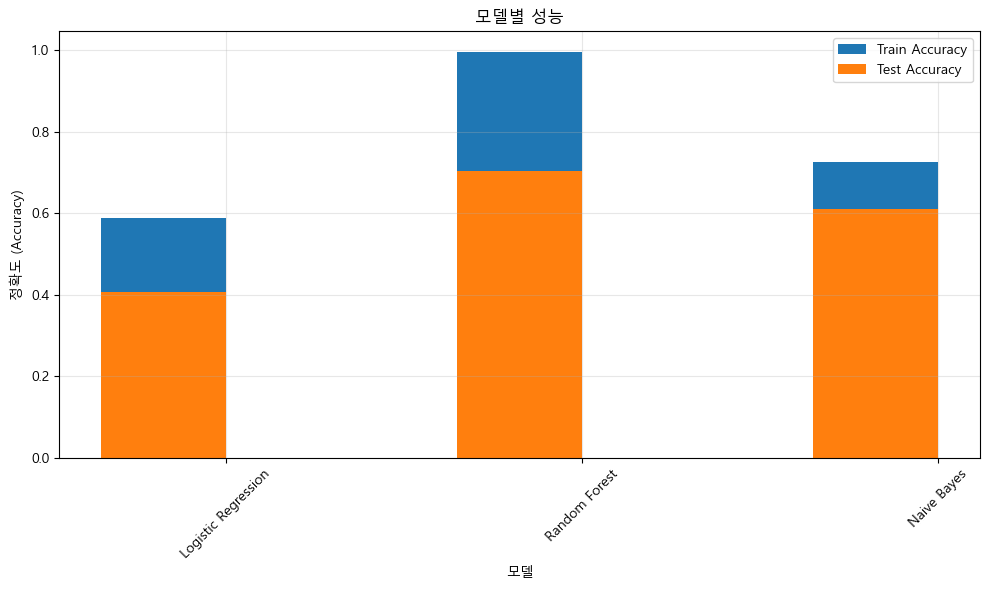

In [80]:
# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

model_names = list(results.keys())  # keys() : 딕셔너리에서 key값만 뽑아낸다. 값 : ['Logistic Regression', 'Random Forest', 'Naive Bayes']
train_accs = [results[name]['train_acc'] for name in model_names]  # 학습 정확도 리스트
test_accs = [results[name]['test_acc'] for name in model_names]    # 테스트 정확도 리스트

x = np.arange(len(model_names))  # x축 위치 (0, 1, 2)
width = 0.35                     # 막대 위치

ax.bar(
    x - width / 2,  # x축 위치는 왼쪽으로 width/2만큼 밀어준다
    train_accs,     # 막대그래프의 y축으로 사용한다.
    width,          # 막대그래프의 두께
    label="Train Accuracy"  # 막대그래프 이름
)  # 학습 정확도 막대그래프
ax.bar(x - width / 2, test_accs, width, label="Test Accuracy")    # 테스트 정확도 막대그래프

ax.set_xlabel("모델")
ax.set_ylabel("정확도 (Accuracy)")
ax.set_title("모델별 성능")
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)  # x축 눈금(모델명)
ax.legend()   # 범례
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

랜덤포레스트는 성능은 가장 우수하였으나, 과적합
나머지 모델들은 과소적합

모델 예측

In [81]:
results

{'Logistic Regression': {'model': LogisticRegression(max_iter=1000, random_state=42),
  'train_acc': 0.5880723781388478,
  'test_acc': 0.406496062992126,
  'test_f1': 0.39615182376580566},
 'Random Forest': {'model': RandomForestClassifier(random_state=42),
  'train_acc': 0.9956917774495323,
  'test_acc': 0.7037401574803149,
  'test_f1': 0.699132508007297},
 'Naive Bayes': {'model': MultinomialNB(),
  'train_acc': 0.7244583948793698,
  'test_acc': 0.6107283464566929,
  'test_f1': 0.5966927309710899}}

In [83]:
# 가장 성능이 좋은 모델 선택
best_model_name = max(results, key=lambda x: results[x]['test_acc'])  # 테스트 정확도가 가장 높은 모델
best_model = results[best_model_name]['model']  # 최고 모델 객체

print(f"최고 성능 모델: {best_model_name}")   # 최고 모델의 이름
print(f"검증 정확도 : {results[best_model_name]['test_acc']:.4f}")     # 최고 모델의 테스트 정확도 (소수점 4자리)
print(f"검증 F1-Score : {results[best_model_name]['test_f1']:.4f}")   # 최고 모델의 테스트 F1-Score 출력 (소수점 4자리)

# 검증 데이터에 대한 예측 (Niave Bayes는 TF-IDF 컬럼(1000개)만 사용하고, 나머지 모델들은 전체 컬럼(1014개)을 사용한다.)
if best_model_name == "Naive Bayes":
    y_test_pred = best_model.predict(X_test_tfidf)                # 예측 레이블
    y_test_pred_proba = best_model.predict_proba(X_test_tfidf)    # 클래스별 확률
else:
    y_test_pred = best_model.predict(X_test_combined)                # 예측 레이블
    y_test_pred_proba = best_model.predict_proba(X_test_combined)    # 클래스별 확률

# 예측 결과의 샘플 5개 확인 (텍스트, 실제/예측 레이블, 신뢰도)
print("\n=== 예측 결과 샘플 ===")
for i in range(5):
    actual_label = label_encoder.inverse_transform([y_test.iloc[i]])[0]          # 실제 레이블 (문자형)으로 반환
    predicted_label = label_encoder.inverse_transform([y_test_pred[i]])[0]  # 예측 레이블 (문자형)으로 반환
    confidence = y_test_pred_proba[i].max()                                      # 예측 신뢰도 (가장 높은 확률)

    print(f"샘플 : {i+1}")
    print(f"텍스트 : {test_df.iloc[i]['text_descriptions'][:50]}...")
    print(f"실제 레이블 : {actual_label}")
    print(f"예측 레이블 : {predicted_label}")
    print(f"신뢰도 : {confidence:.3f}")


최고 성능 모델: Random Forest
검증 정확도 : 0.7037
검증 F1-Score : 0.6991

=== 예측 결과 샘플 ===
샘플 : 1
텍스트 : 가방 $80$개를 $4$개의 상자에 똑같이 나누어 담았습니다. 상자 한 개에 담은 가방은 ...
실제 레이블 : 초등학교 3학년
예측 레이블 : 초등학교 3학년
신뢰도 : 0.760
샘플 : 2
텍스트 : 학생 $120$명이 체육대회에 참여했습니다. $600$개의 장난감을 학생들에게 똑같이 나누...
실제 레이블 : 초등학교 3학년
예측 레이블 : 초등학교 3학년
신뢰도 : 0.610
샘플 : 3
텍스트 : 사탕 225개를 15개의 박스에 똑같이 나누어 담았습니다. 박스 한 개에 담은 사탕은 몇 ...
실제 레이블 : 초등학교 3학년
예측 레이블 : 초등학교 3학년
신뢰도 : 0.980
샘플 : 4
텍스트 : 도서관에 책 $270$권이 있습니다. 이 책을 $9$개의 책꽂이에 똑같이 나누어 놓으면, ...
실제 레이블 : 초등학교 3학년
예측 레이블 : 초등학교 3학년
신뢰도 : 0.910
샘플 : 5
텍스트 : 기차 8대에 320명의 승객이 탑승했습니다. 기차 한 대에 탑승한 승객은 몇 명일까요?...
실제 레이블 : 초등학교 3학년
예측 레이블 : 초등학교 3학년
신뢰도 : 0.690


성능 지표 계산 

In [ ]:
test_accuarcy = accuracy_score(y_test,y_test_pred) # 정확도
test_precision = precision_score(y_test,y_test_pred,average='weighted') # 정밀도 (가중 평균)
test_recall = recall_score(y_test,y_test_pred,average='weighted')   # 재현율 (가중 평균 : 클래스 불균형이 있더라도 감안해서 불균형한쪽의 가중치를 높여서 1:1로 맞춰준다)
test_f1 = f1_score(y_test,y_test_pred, average='weighted')

print(f"정확도 (Accuarcy): {test_accuarcy:.4f}")
print(f"정밀도 (Precision): {test_precision:.4f}")
print(f"재현율 (Recall): {test_recall:.4f}")
print(f"F1-Score : {test_f1:.4f}")


정확도 (Accuarcy): 0.7037
정밀도 : 0.7061
재현율 : 0.7037
F1-Score : 0.6991


In [86]:
print('=== classification report ===')
print()
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

=== classification report ===

              precision    recall  f1-score   support

    고등학교 1학년       0.57      0.54      0.55       119
     중학교 1학년       0.74      0.68      0.71       345
     중학교 2학년       0.81      0.80      0.81       357
     중학교 3학년       0.70      0.87      0.78       316
    초등학교 3학년       0.59      0.79      0.68       206
    초등학교 4학년       0.50      0.38      0.43       208
    초등학교 5학년       0.82      0.59      0.69       229
    초등학교 6학년       0.75      0.77      0.76       252

    accuracy                           0.70      2032
   macro avg       0.68      0.68      0.67      2032
weighted avg       0.71      0.70      0.70      2032



여기서 f1스코어가 낮은 초등학교 4학년은 이상치 처리를 더 해야 될 것으로 보이고 고등학교 1학년은 데이터를 증강시키는 방법을 쓰면 좋겠다

In [ ]:
class_report = classification_report(
    y_test,                                 # 실제 정답 레이블
    y_test_pred,                            # 예측 결과 레이블
    target_names=label_encoder.classes_,    # 각 클래스 이름 리스트(문자형)
    output_dict=True                        # 표 대신 딕셔너리로 변환
    )

class_report

{'고등학교 1학년': {'precision': 0.5663716814159292,
  'recall': 0.5378151260504201,
  'f1-score': 0.5517241379310345,
  'support': 119.0},
 '중학교 1학년': {'precision': 0.7358490566037735,
  'recall': 0.6782608695652174,
  'f1-score': 0.7058823529411765,
  'support': 345.0},
 '중학교 2학년': {'precision': 0.8101983002832861,
  'recall': 0.8011204481792717,
  'f1-score': 0.8056338028169014,
  'support': 357.0},
 '중학교 3학년': {'precision': 0.7007672634271099,
  'recall': 0.8670886075949367,
  'f1-score': 0.7751060820367751,
  'support': 316.0},
 '초등학교 3학년': {'precision': 0.5934065934065934,
  'recall': 0.7864077669902912,
  'f1-score': 0.6764091858037579,
  'support': 206.0},
 '초등학교 4학년': {'precision': 0.4968553459119497,
  'recall': 0.3798076923076923,
  'f1-score': 0.4305177111716621,
  'support': 208.0},
 '초등학교 5학년': {'precision': 0.8192771084337349,
  'recall': 0.5938864628820961,
  'f1-score': 0.6886075949367089,
  'support': 229.0},
 '초등학교 6학년': {'precision': 0.752895752895753,
  'recall': 0.77380

- 혼동 행렬 시각화
    - 혼동 행렬은 분류 모델 성능 평가시 사용하는 오차 행렬
    - 모델이 예측 결과와 실제값을 비교해서 얼마나 맞추고 틀렸는지를 정리해서 볼 수 있다.

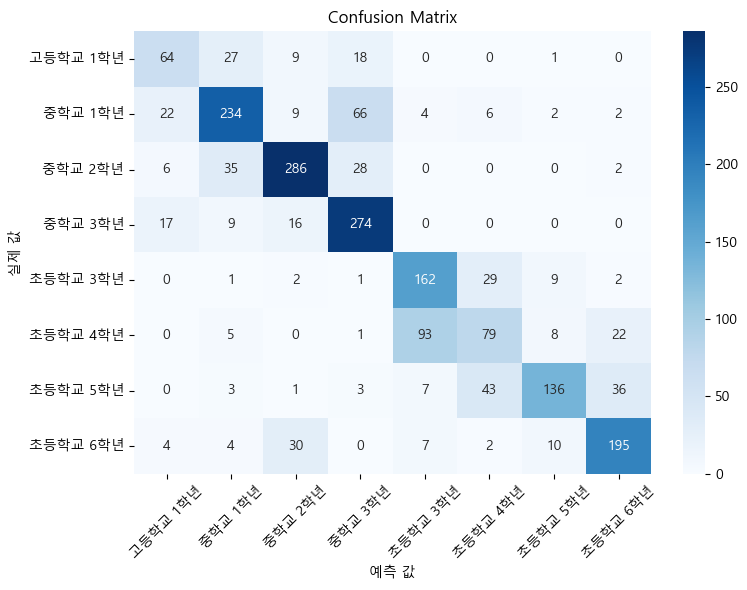

In [90]:
cm = confusion_matrix(y_test,y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(
    cm,                                 # 혼동행렬 데이터
    annot=True,                         # 각 칸에 숫자 표시
    fmt='d',                            # 정수형으로 포멧팅
    cmap='Blues',                       # 컬러맵
    xticklabels=label_encoder.classes_, # 예측 클래스 이름(x축) 
    yticklabels=label_encoder.classes_  # 실제 클래스 이름(y축)
)

plt.title('Confusion Matrix')
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

모델이 실제값과 예측값의 오차를 계산해보니 학교급 내에서의 구분이 어려웠다  => 파생변수를 좀더 만들어도 되고, TF-IDF특성을 좀더 늘려봐도괴고 데이터를 더 구해봐도 되고

In [ ]:
class_report.items()    # 메트릭스는 딕셔너리 형태

dict_items([('고등학교 1학년', {'precision': 0.5663716814159292, 'recall': 0.5378151260504201, 'f1-score': 0.5517241379310345, 'support': 119.0}), ('중학교 1학년', {'precision': 0.7358490566037735, 'recall': 0.6782608695652174, 'f1-score': 0.7058823529411765, 'support': 345.0}), ('중학교 2학년', {'precision': 0.8101983002832861, 'recall': 0.8011204481792717, 'f1-score': 0.8056338028169014, 'support': 357.0}), ('중학교 3학년', {'precision': 0.7007672634271099, 'recall': 0.8670886075949367, 'f1-score': 0.7751060820367751, 'support': 316.0}), ('초등학교 3학년', {'precision': 0.5934065934065934, 'recall': 0.7864077669902912, 'f1-score': 0.6764091858037579, 'support': 206.0}), ('초등학교 4학년', {'precision': 0.4968553459119497, 'recall': 0.3798076923076923, 'f1-score': 0.4305177111716621, 'support': 208.0}), ('초등학교 5학년', {'precision': 0.8192771084337349, 'recall': 0.5938864628820961, 'f1-score': 0.6886075949367089, 'support': 229.0}), ('초등학교 6학년', {'precision': 0.752895752895753, 'recall': 0.7738095238095238, 'f1-score': 

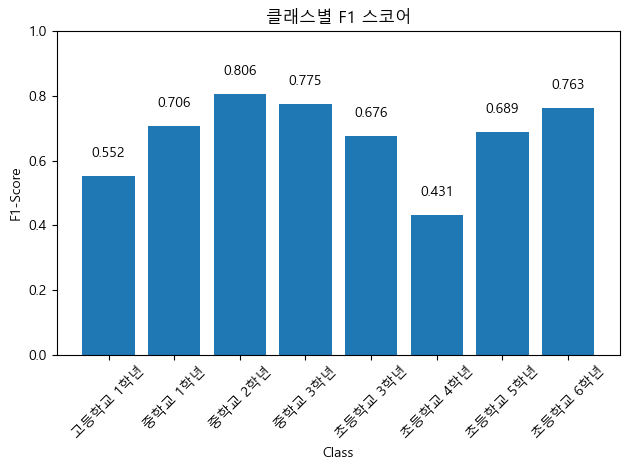

In [101]:
# 클래스별 성능 시각화
class_report = classification_report(
    y_test,                                 # 실제 정답 레이블
    y_test_pred,                            # 예측 결과 레이블
    target_names=label_encoder.classes_,    # 각 클래스 이름 리스트(문자형)
    output_dict=True                        # 표 대신 딕셔너리로 변환
    )

# F1-스코어만 추출(정확도, 평균 제외)
class_f1_scores = {
    cls : metrics['f1-score']
    for cls, metrics in class_report.items() if cls not in ['accuracy','macro avg', 'weighted avg']
}

class_f1_scores

classes = list(class_f1_scores.keys())
f1_scores =list(class_f1_scores.values())

# 막대 그래프로 시각화
bars = plt.bar(classes,f1_scores) # 막대 그래프 그리기
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('클래스별 F1 스코어')
plt.xticks(rotation=45)
plt.ylim(0,1.0)                     # y축 범위 (0~1)

#  각 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,  # x: 막대 중앙
        height + 0.05,                               # y: 막대 높이(윗부분)
        f"{height:.3f}",                      # 표시할 텍스트
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

어던 피처가 이 모델에서 중요성을 가지는지를 체크하면 성능을 조금 더 향상시킬 수 잇따.

- 모델 해석
    - 특성 중요도(Feature impoertance) 분석

In [107]:
print(best_model.feature_importances_)
print()
print(tfidf_vectorizer.get_feature_names_out())
print()
# print(feature_importance.argsort()[-20:][::-1])

[0.00196814 0.00018716 0.00012618 ... 0.01377567 0.01153899 0.01174416]

['10' '10 frac' '10 mathrm' '10 mathrm cm' '100' '10cm' '11' '12' '120'
 '12cm' '13' '14' '15' '16' '17' '18' '180' '19' '1개' '1층' '1층에' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '2cm' '2개' '2층' '2층에' '2행' '30'
 '30 circ' '32' '35' '36' '3cm' '3개' '40' '40 circ' '42' '45' '45 circ'
 '48' '4cm' '4개' '4개의' '50' '5cm' '5개' '60' '60 circ' '65' '6cm' '70' '72'
 '75' '7cm' '80' '8cm' '90' '90 circ' '90 circ 직각삼각형' '9cm' 'ab'
 'ab mathrm' 'ab mathrm cm' 'ab overline' 'ab overline mathrm' 'ab 길이는'
 'abc' 'abc 에서' 'abc 에서 overline' 'abcd' 'abcd가' 'abcd에서'
 'abcd에서 overline' 'abcd에서 overline mathrm' 'abcd의' 'abc가' 'abc를' 'abc에서'
 'abc에서 overline' 'abc에서 overline mathrm' 'abc와' 'abc의' 'abd' 'ab는' 'ab와'
 'ab의' 'ab의 길이는' 'ac' 'ac overline' 'ac overline mathrm' 'ac는' 'ac의' 'ad'
 'ad overline' 'ad overline mathrm' 'ae' 'ah' 'aligned' 'alpha' 'angle'
 'angle angle' 'angle mathrm' 'angle mathrm 90' 'angle mathrm angle'
 'angle

In [ ]:
feature_importance = best_model.feature_importances_    # 특징 중요도 가져오기

tfidf_features = list(tfidf_vectorizer.get_feature_names_out()) # TF-IDF 특징 이름

additional_features = list(train_features.columns)  # 추가 특징 이름 naive bayes는 빼고 한다

all_features = tfidf_features + additional_features # 전체 특성 이름

top_features_idx = feature_importance.argsort()[-20:][::-1] # 상위 20개 중요 특징 (내림차순 정렬)

# feature_importance.argsort()[-20:][::-1]

for idx in top_features_idx:
    if idx < len(all_features):
        print(f"{all_features[idx]} : {feature_importance[idx]:.4f}")   # 특징명, 중요도

# 특징 유형별 중요도 합산 비교
tfidf_importance = feature_importance[:len(tfidf_features)].sum()       # TF-IDF 중요도 합
addtional_importance = feature_importance[len(tfidf_features):].sum()   # 추가 특징 중요도 합

print(f"\nTF-IDF 특징 중요도 : {tfidf_importance:.4f}")
print()
print(f"추가 특징 중요도 : {addtional_importance:.4f}")


avg_word_length : 0.0294
text_length : 0.0292
math_symbol_count : 0.0266
word_count : 0.0262
보세요 : 0.0232
num_count : 0.0212
다음 : 0.0187
구하시오 : 0.0143
sentence_count : 0.0138
선택하세요 : 0.0136
parenthesis_count : 0.0117
question_count : 0.0115
오른쪽 : 0.0102
sqrt : 0.0100
frac : 0.0084
has_calculation : 0.0080
계산하시오 : 0.0076
div : 0.0075
일차함수 : 0.0074
mathrm : 0.0070

TF-IDF 특징 중요도 : 0.8123

추가 특징 중요도 : 0.1877


질문의 길이, 보세요, 다음, 구하시오 이러한 단어들이 유의미하게 판단하였다. 14개로 수는 적었지만 추가 특징이 굉장히 판단하는데 유의미하게 기여하였다

- 앙상블 모델 구축
    - VotingClassifier 사용한다

In [115]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB

lr_for_ensemble = LogisticRegression(
    C=10.0,         # 정규화는 약하게
    max_iter=1000,  # 반복횟수
    random_state=42 # 시드 고정, 재현성
    )

rf_for_ensemble = RandomForestClassifier(
    n_estimators= 100, # 트리의 개수
    random_state=42     
)

nb_for_ensemble = MultinomialNB()   # 다항 나이브베이즈
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_for_ensemble),    # 로지스틱 회귀
        ('rf',rf_for_ensemble),     # 랜덤 포레스트
        ('nb',nb_for_ensemble)      # 나이브베이즈
    ],
    voting='soft' # 소프트 보팅 : 예측 확률 평균
)

ensemble_model.fit(X_train_combined,y_train)    # 모델 학습
ensemble_predictions = ensemble_model.predict(X_test_combined)

ensemble_accuarcy = accuracy_score(y_test, ensemble_predictions)                # 정확도
ensemble_f1_score = f1_score(y_test, ensemble_predictions, average='weighted')  # 가중평균 사용 F1스코어

print(F"정확도 {ensemble_accuarcy}")
print(F"F1 스코어 {ensemble_f1_score}")

print("\n 개별모델과 앙상블 모델 비교")
for name, result in results.items():
    print(f"{name} : {result["test_f1"]:.4f}")
print(f"앙상블 모델 : {ensemble_f1_score:.4f}")

정확도 0.6264763779527559
F1 스코어 0.625250713524152

 개별모델과 앙상블 모델 비교
Logistic Regression : 0.3962
Random Forest : 0.6991
Naive Bayes : 0.5967
앙상블 모델 : 0.6253


앙상블을 한다고해서 무조건 성능이 좋아지는것은 아니다. 부스팅 계열 모델을 사용해보는것이 좋을것 같다 |